<h1><center><b>Multilingual Semantic Role Labeling</b></center></h1>

---

# Introduction

The concept of “semantic role labeling” (who did what to whom) for sentences in French is explored. English semantic role labeling has been heavily studied for decades. However, porting semantic role labeling to non-English languages requires training on the non-English language to create a new model for that language.

- Part 1 sets up the environment through installation of the required dependencies and requires a kernel restart once the installation finishes.
- Part 2 explains semantic role labeling and Allennlp Model
- Part 3 explores XSRL
- Part 4 explores BERT
- Part 5 converts data
- Part 6 projects English SRL labels to French SRL labels
- Part 7 trains AllenNLP with projected French dataset
- Part 8 visualizes French SRL
- Part 9 evaluates French SRL

> "@DonozoKortess2 @MLP_officiel plus le coup d'etat, (plutot les coups d'etats) , les restrictions des libertés individuelles et collectives",
> "@Greguyyyy @HalbeardD @Tlibdij @JLMelenchon @BurgerKingFR Honnêtement le capitalisme a été génial sur cette période…"


The folder structure after extracting the ZIP file is as follows:

> src : Source files

> data : Given data needed to run codes

> saving_file : Location where the files to be saved _This folder is empty initially._

The list below is a list of files you are given, followed by a list of files that you will create by the end of this project.

Given data _(Directory : data)_

-     00_french_election_french_spacy_sentences.txt
-     01_french_election_english_spacy_sentences.txt
-     02_French_CoNLL.Conll
-     03_English_CoNLL.Conll
-     04_error_sentences.txt
-     05_english_extended_CoNLL.conll
-     06_irr_index.pkl
-     07_test_set.pkl
- 08_SRL_train.jsonnet
- 09_french_objects_100.pkl
- 10_english_objects_100.pkl
- train/French_SRL_allennlp_train.gold_conll
- valid/French_SRL_allennlp_valid.gold_conll
- test/French_SRL_allennlp_test.gold_conll
- en_obj_test.pkl
- fr_obj_test.pkl
- align_result.pkl

Files to be created _(saved in saving_file)_

- clean_English_extended_CoNLL.conll
- clean_French_CoNLL.conll
- clean_French_CoNLL.conll.S2T.populated
- french_allennlp_extended_CoNLL.conll
- fr_obj.pkl
- en_obj.pkl
- srl_align_result.html


## Part 1 : Setting up the environment


### Install dependencies

[**AllenNLP**](https://guide.allennlp.org/overview#1) is a NLP research library built on PyTorch that provides state-of-the-art deep learning models on various NLP tasks. [**Pyconll**](https://pyconll.readthedocs.io/en/stable/) helps you to manage CoNLL files with the syntax of python and has been installed for reading CoNLL-u files, but it is recommended that you also examine the [X-SRL code](https://github.com/Heidelberg-NLP/xsrl_mbert_aligner/blob/main/project_srl_annotations.py) to see how SRL annotations are added to the CoNLL files. Some of the code below might be useful when you are trying to build the english SRL-annotated CoNLL file that will be projected onto the french conll file. **NLTK "omw"** stands for Open Multilingual Wordnet, enabling the use of wordnets in multiple languages.


In [ ]:
%pip install allennlp
%pip install allennlp-models
%pip install spacy
%pip install bert_score
%pip install --upgrade huggingface-hub==0.24.0
%pip install -U nltk

!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!python -m spacy download fr_core_news_sm
!python -m spacy download fr_core_news_md

import os
import re
import nltk
import math
import copy
import random
import pickle
import pandas as pd
import numpy as np
from allennlp.predictors.predictor import Predictor
from transformers import BertTokenizer, BertForMaskedLM, logging
import torch
from tqdm import tqdm
from IPython.display import display, HTML

logging.set_verbosity_error()
nltk.download('omw-1.4')

After running the code cell below, you are expected to see this result:


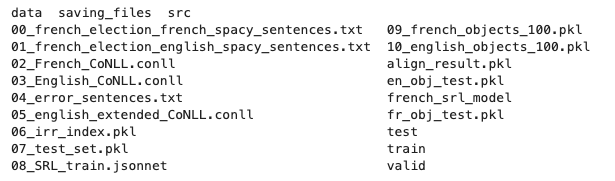


After running the code cell below, you are expected to see the given result.


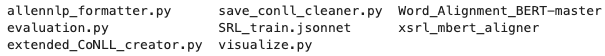


In [ ]:
dir2 = path+'/src'

%cd -q $dir2
!ls

from visualize import view
from evaluation import measure, confu_matrix
from save_conll_cleaner import save_conll_cleaner, remove_problem_set, get_agg_string, remove_from_text

## Part 2 : Exploring Semantic Role Labeling and Allennlp Model

### What is semantic role labeling?

This is a task that assigns semantic roles to "chunks" (or "spans of words") in sentences. Assignment of semantic roles brings together linguistic representations (semantic roles) with machine learning to yield a representation that tells us "who did what to whom".


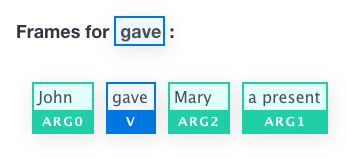


In general :

- ARG0 is **the agent of the action**
- ARG1 is **the object that is moved or in some way affected**
- ARG2 is **generally the beneficiary, instrument, or end state of the action**

However, what happens when one runs the sentence _John gave a present to Mary_. Note that the role assignment is the same for either construction. That is, semantic roles are intended to get at the same underlying "meaning" of the sentence, regardless of the way in which that meaning is conveyed.

For this project, our central question shifts to this: What happens when we want to run semantic role labeling on a non-English language, but all we have is semantic role labeling for English? Consider this example (the French translation of _John gave Mary a present_):

> _Jean a offert un cadeau à Marie_

One would hope that Jean(=John) would be ARG0, cadeau(=gift) would be ARG1, and Marie(=Mary) would be ARG2, just as in the English equivalent. But how can we bring about this equivalence? Let's explore this question to see how far we can get, and to examine the challenges that arise along the way.


### Semantic Role Labeling(SRL) model in Allennlp

AllenNLP provides an English SRL model.

```
Model Name : SRL BERT
Version : 1
Training dataset size : 1.4 million words
Archive File : https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz
```

This model predict semantic role labels with corresponding predicates(verb) in the tokens. Allennlp built SRL model based on a BERT(Bidirectional Encoder Representations from Transformers), which is the state of the art model for English PropBank SRL. Additional information about BERT is provided in part 3.


In [ ]:
en_srl_predictor = Predictor.from_path(
    "https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz",
    predictor_name="semantic_role_labeling",
)

active = "Jendi sent Andrew a present"
passive = "A present was sent to Andrew by Jendi"

**Expected Output**

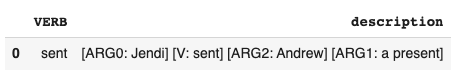

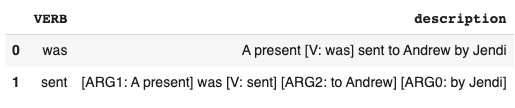


Note that in the sentence above, the bracketed "head" of the semantic role frame is marked [V:...], and it is this head that takes the other three arguments.


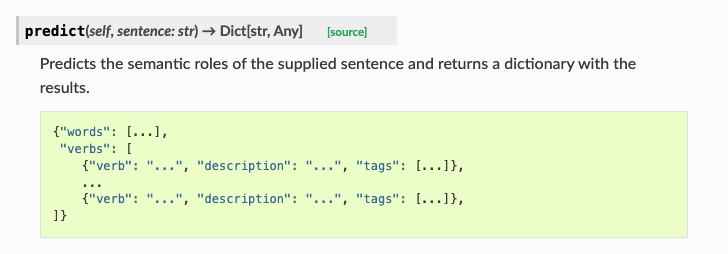


In [ ]:
def srl_prediction(model, sent):
    result = model.predict(sentence=sent)
    verbs = result["verbs"]
    data = []
    for v in verbs:
        data.append(
            {"verb": v["verb"], "description": v["description"], "tags": v["tags"]}
        )
    return pd.DataFrame(data)

In [ ]:
active_df = srl_prediction(en_srl_predictor, active)
passive_df = srl_prediction(en_srl_predictor, passive)

display(HTML(active_df.to_html()))
display(HTML(passive_df.to_html()))

In [ ]:
sentence_1 = "I'm not sure whether he will come to the party tomorrow"

test_sent_df = srl_prediction(en_srl_predictor, sentence_1)
display(HTML(test_sent_df.to_html()))

In [ ]:
sentence_2 = "I'm not sure whether he will come to the party tomorrow"
example_df = srl_prediction(en_srl_predictor, sentence_2)

display(HTML(example_df.to_html()))

### Building AllenNLP model

AllenNLP's guide Part 1, describes the basics for machine learning models for a range of different NLP tasks. The guide presents a methodology for efficiently building models for many AllenNLP tools, with the exception of semantic role labeling. In order to train a semantic role labeling model, additional information is provided in the task below.


## Part 3: Understanding XSRL

### What is XSRL?

In order to build training data for an AllenNLP French SRL model, we must first apply SRL to English sentences, after which we will project English SRL labels to French. We make use of another github repository ([X-SRL](https://github.com/Heidelberg-NLP/xsrl_mbert_aligner)) for this projection task. Then, using the SRL-labeled French sentences we train the AllenNLP French SRL model. Both the French sentences (tweets split using spacy's sentence splitter) and the English translated sentences are provided in the data folder for the project. Each file (french_election_french_spacy_sentences.txt and french_election_english_spacy_sentences.txt) has one sentence per line as split by spaCy as indicated in the name of the file.

### How it works

X-SRL applies multilingual BERT(mBERT) to project high quality annotations to the target languages(DE, ES, FR). mBERT is a pretrained model on the top 104 languages with the largest Wikipdedia.

The X-SRL model translates the English CoNLL-09 SRL dataset into target languages. The X-SRL data set focuses only on verbal predicates.

The X-SRL model use an mBERT embedding space to compute pair-wise cosine similarity between source and target tokens(Source : English, Target : French in this project) and the resulting word-alignment is used for projection.

The figure below is an example for Spanish from the above cited paper, where you can read more about X-SRL. Note that the source and target sentences both have a head verb (which means "sound.01") and two arguments abbreviated "A1" (for ARG1) and "A2" (for ARG2), mediated by word alignments from English to Spanish.


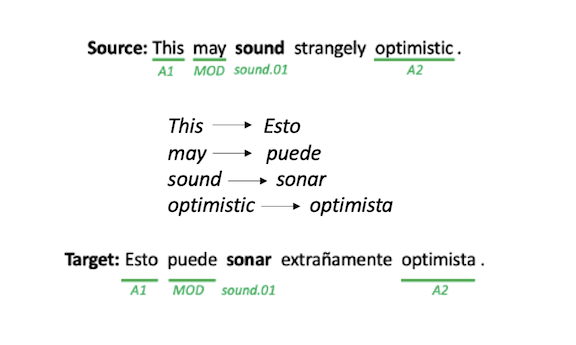


You can find detailed information about X-SRL in the following link, [X-SRL](https://aclanthology.org/2020.emnlp-main.321.pdf)


## Part 4 : Understanding BERT

The Allennlp SRL model that uses BERT is called SRL-BERT. X-SRL also incorporates mBERT to find accurate word-level alignments across languages.
In this part, you will explore the concept of BERT with several tasks.

### What is BERT?

Bidirectional encoders incorporate a self-attention mechanism, which ranges over all words in the text simultaneously. In other words, the bidirectional encoder generates output vectors that have been contextualized, thus serving as a significant advance over word2vec. The original BERT model(bert-base-uncased) is pretrained with a vocabulary of 30,000 tokens. The model consists of hidden layers of the size of 768 and 12 layers of transformer blocks, with 12 multihead attention layers each. BERT allows us to do fine-tuning with pretrained models. This pretrain-finetune mechanism is an example of transfer learning in machine learning. This paradigm enables the model to efficiently acquire the requirements of a downstream language task such as semantic role labeling, named entity tagging, or question answering.

Two types of objective functions(Next Sentence Prediction, Masked Language Models) are used in BERT training. For SRL-BERT, the predicate identification and classification model needs to be trained to identify and label, e.g., "send" as the predicate in "send a present".


#### Next Sentence Prediction (NSP)

An important NLP task of pre-training BERT involves determining the relationship between sentence pairs. BERT introduces "next sentence prediction" (NSP) to capture this. The model is given sentence pairs and is asked to predict if the pair represents actual adjacent sentences from the training corpus or if the pair represents unrelated sentences. In BERT experiments, when selecting training pairs (two sentences A and B), 50% of the training pairs (A and B) consist of actual sentences pairs (B follows A), and in the other 50% of pairs, sentence B is randomly selected from the corpus, and A and B are not actual pairs. NSP introduced new tokens called [CLS](Special classification token) and [SEP](Special seperation token). [CLS] is prepended to the input sentence pair, and [SEP] is usally located between the sentences--after the final token of the first sentence.


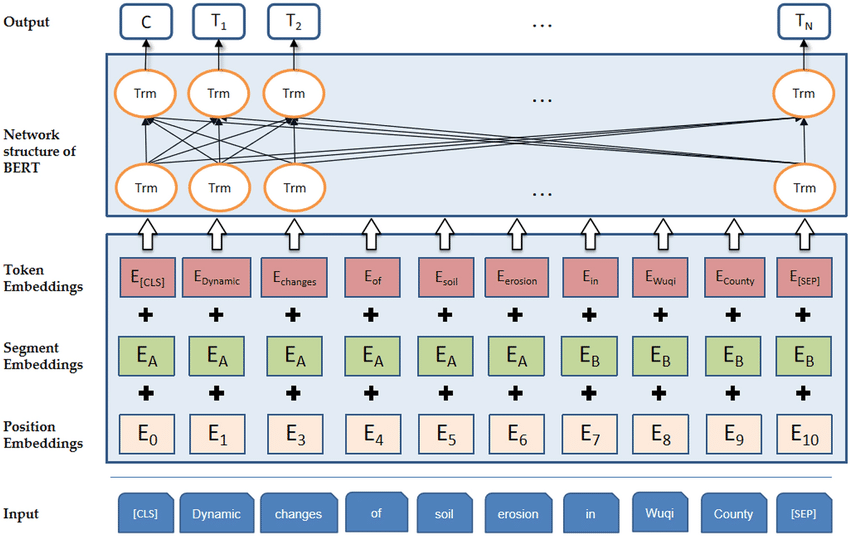


#### **Programming Question #2:** (4 points)

#### **Complete the code below to define the function for the Bert Tokenizer.** Follow this link to help you complete code below [Transformers/BertTokenizer](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.convert_ids_to_tokens). This function will be used in 3.1.2 below.

<mark>After you have completed the function and executed the tests, make sure to transfer your answer to the .py file provided along with this Notebook.</mark>

We use "from_bert-base-uncased" as a pre-trained model for tokenizer, and
you can obtain tokens and special tokens.

_Data Sources_

> BooksCorpus : 800M words

> English Wikipedia : 2500M words

**Test Sentence**

> Rob went to Rome

**Expected output**

```
['[CLS]', 'rob', 'went', 'to', 'rome', '[SEP]']
```


In [ ]:
from transformers import BertTokenizer


def get_bert_tokens(sent):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    inputs = tokenizer(sent, return_tensors="pt")
    return tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

#### Predicate identification and classification model

> The completion of this section prepares you to answer question 5 and 6 on **Project 3 Quiz questions**.

SRL-BERT uses a pre-trained NSP model and predicate indentification and classification model. To train predicate identification and classification model, [SEP] is used for representing predicates as well as separating sentences. Thus, the existing BERT contextual embedding is concatenated to the predicate embeddings. You can find additional details about this in follow link [SRL-BERT](https://www.semanticscholar.org/paper/Simple-BERT-Models-for-Relation-Extraction-and-Role-Shi-Lin/fddbcabe0fc9be0684855ae3dd059fb525a69e5b).


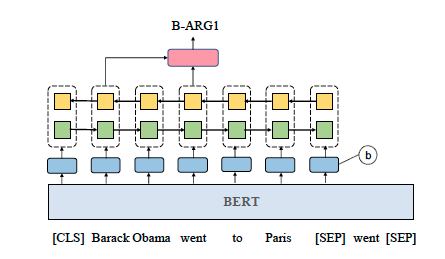


In SRL-BERT, (b) denotes the concatenation of BERT contextual embedding and predicate embedding.


In [ ]:
test_sentence = "Rob went to Rome"
print(get_bert_tokens(test_sentence))

**Output from BERT**

```
['[CLS]', 'rob', 'went', 'to', 'rome', '[SEP]']
```

**Consider an alternative output from SRL-BERT, which concatenates each predicate to the end, as shown in the figure above:**

```
['[CLS]', 'rob', 'went', 'to', 'rome', '[SEP]', went,'[SEP]']
```


#### Masking Words

Masked Language Modeling(MLM) is the model used for pre-training BERT. MLM was the original approach to train bidirectional encoders.
In BERT, 15% of the input tokens in a training sequence are sampled for learning, 80% of them are replaced with [MASK], 10% of them are randomly chosen tokens, and the remaining 10% of them are unchanged. Through the MLM training, the bidirectional model can predict the original tokens for each masked token. With the simple BERT tutorial below, you can explore how masking words are trained in BERT using transformers.

_Example_

80% of the time : Replace the token with the [MASK],

```
the girl goes to the gym  -> the girl goes to the [MASK]
```

10% of the item : Replace the token with randomly chosen token,

```
the girl goes to the gym -> the girl goes to the cereal
```

10% of the time : Keep the token unchanged,

```
the girl goes to the gym -> the girl goes to the gym
```


### **Programming Question #3:** (3 points)

#### **Complete the code below to define the function for predicting Masked token**

<mark>After you have completed the function and executed the tests, make sure to transfer your answer to the .py file provided along with this Notebook.</mark>

Pre-trained model "bert-base-uncased" is trained using NSP and MLM. Since this model is trained from large datasets (BookCorpus, 800M words, English Wikipedia : 2,500words), it's possible to find answers for general questions like those below, because the model is pre-trained using MLM.

> Question : The capital of France is [MASK]

> Answer : The capital of France is paris


**Expected output for a question below:**

```
The capital of Italy is rome
```


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForMaskedLM.from_pretrained("bert-base-uncased")

In [ ]:
def masked_learning(tokenizer, model, country):
    question = "The  capital of " + country + " is [MASK]."

    inputs = tokenizer(question, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    index_for_masked_token = (inputs.input_ids == tokenizer.mask_token_id)[0].nonzero(
        as_tuple=True
    )[0]
    id_for_predicted_token = logits[0, index_for_masked_token].argmax(dim=-1)

    city = tokenizer.decode(id_for_predicted_token)

    return "The capital of {} is {}".format(country, city)

In [ ]:
country = "Italy"
masked_learning(tokenizer, model, country)

# Part 5 : Converting Data format

Project English SRL labels to French using a github repository (X-SRL), and then train the AllenNLP French SRL model using the French labeled data. **To train data using Allennlp trainer, we need to change the format of data, and it requires several steps to transform to Allennlp training format**

> _text -> CoNLL -> Extended CoNLL(CoNLL with SRL tags) -> AllenNLP training format_


### Text to CoNLL format

**First**, the English sentences must be put into the appropriate CoNLL format that X-SRL requires ([CoNLL-U](https://universaldependencies.org/format.html)). Luckily the X-SRL repository provides a script that can preprocess a text file of sentences and turn them into the appropriate CoNLL format.

```
%cd /content/drive/MyDrive/Project03/src
!python pre_process/text_to_CoNLL.py \
    --src_file "/content/drive/MyDrive/Project03/data/00_french_election_french_spacy_sentences.txt" \
    --out_file "/content/drive/MyDrive/Project03/saving_files/02_French_CoNLL.conll" \
    --lang FR \
    --add_syntax True
```

**Second**, the above script must also be run on the French sentence file as they both need to be in CoNLL format.

English, French CoNLL file are already given in data folder

- 02_French_CoNLL.conll
- 03_English_CoNLL.conll


### CoNLL into Extended CoNLL(including SRL tags)

Note that the English CoNLL file created by the preprocessing script does not include any SRL labels. The next step is thus to augment the CoNLL file with SRL labels. In order to do this, the English sentences must be run through AllenNLP's SRL predictor. The output of the predictor must then be applied to the corresponding sentence in the CoNLL file. The final result will appear as shown below.

```
1	A	a	DET	DT	_	2	det	_	_	_	B-ARG0
2	journalist	journalist	NOUN	NN	_	6	nsubj	_	_	_	I-ARG0
3	like	like	SCONJ	IN	_	2	prep	_	_	_	I-ARG0
4	Moix	Moix	PROPN	NNP	_	3	pobj	_	_	_	I-ARG0
5	can	can	VERB	MD	_	6	aux	Y	_	B-V	B-ARGM-MOD
6	insult	insult	VERB	VB	_	6	ROOT	Y	_	_	B-V
7	the	the	DET	DT	_	9	det	_	_	_	B-ARG1
8	Pen	Pen	PROPN	NNP	_	9	compound	_	_	_	I-ARG1
9	marine	marine	NOUN	NN	_	6	dobj	_	_	_	I-ARG1
10	,	,	PUNCT	,	_	9	punct	_	_	_	I-ARG1
11	a	a	DET	DT	_	13	det	_	_	_	I-ARG1
12	presidential	presidential	ADJ	JJ	_	13	amod	_	_	_	I-ARG1
13	candidate	candidate	NOUN	NN	_	9	appos	_	_	_	I-ARG1
14	like	like	SCONJ	IN	_	13	prep	_	_	_	I-ARG1
15	the	the	DET	DT	_	16	det	_	_	_	I-ARG1
16	others	other	NOUN	NNS	_	14	pobj	_	_	_	I-ARG1
17	?	?	PUNCT	.	_	6	punct	_	_	_	_
```

In this example file each column **after the 11th column has SRL labels in it; each SRL label is tied to a verb in the sentence**. Even though the column itself does not specifically identify the token that is the verb corresponding to the SRL labels, the columns are associated with the verb in the order that each verb is encountered in the sentence. Luckily this is the same way AllenNLP's output is ordered. Additionally, we need to add one more column that represents the existence of "predicates" to use XSRL model.


To project English SRL into French data, we must fit data to mBERT-XSRL required format, in which there is a new column that indicates the existence of predicates using "Y"(Y means the token is a "predicate"). You can find annotation information through PropBank Guidelines.[Here](https://verbs.colorado.edu/~mpalmer/projects/ace/PBguidelines.pdf)

Three files (english_extended_CoNLL.conll, error_sentences.txt, irr_index.pkl) are provided in a data folder. Some examples from 04_error_sentences and 05_english_extended_CoNLL.conll are used to answer question 5 below.


There are some irrelevant sentences that cause an error. We already saved the index of irrelevant sentences. You are going to remove irrelevant sentences from the 02_French_CoNLL.conll and 05_english_extend_Conll.conll. After removing irrelevant data, **25549 sentences (708135 words)** are remained, and they are used for train/validation/test.


In [ ]:
%cd -q $dir1
saving_path = path+'/saving_files'

if __name__ == '__main__' :
    eng = "05_english_extended_CoNLL.conll"
    fra = "02_French_CoNLL.conll"
    clean_english_extend_conll = saving_path+"/clean_English_extended_CoNLL.conll"
    clean_french_conll = saving_path+"/clean_French_CoNLL.conll"

    irr_index = "06_irr_index.pkl"
    with open(irr_index, "rb") as f :
      irr_index = pickle.load(f)

    #Remove irrelevant sentences from English and French conll file
    eng_extend_list, fra_conll_list = remove_problem_set(eng, fra, irr_index)

    save_conll_cleaner(clean_english_extend_conll,
            eng_extend_list,
            clean_french_conll,
            fra_conll_list)

Extended CoNLL columns guideline

1. ID: Word index, integer starting at 1 for each new sentence; may be a range for multiword tokens; may be a decimal number for empty nodes (decimal numbers can be lower than 1 but must be greater than 0).

2. FORM: Word form or punctuation symbol.

3. LEMMA: Lemma or stem of word form.

4. UPOS: Universal part-of-speech tag.

5. XPOS: Language-specific part-of-speech tag; underscore if not available.

6. FEATS: List of morphological features from the universal feature inventory or from a defined language-specific extension; underscore if not available.

7. HEAD: Head of the current word, which is either a value of ID or zero (0).

8. DEPREL: Universal dependency relation to the HEAD (root iff HEAD = 0) or a defined language-specific subtype of one.

9. PREDICATE : If a word is predicte, "Y", or "N".

10. MISC : Any other annotation if a word has one.

11. SEMANTIC ROLE : From this column, Semantic Role labels are assigned here. Columns 11, 12, etc. are each associated with a corresponding predicate. For example, ARG2 in column X, is associated with the (X-10)th predicate in the sentence. i.e. The SRL in 11th column is associated with the 1st predicate.


There are two English CoNLL examples and two Error examples : 1 and 2 from 05_english_extened_CoNLL.conll(English sentence with SRL tags), 3 and 4 from 04_error_sentences.txt
In this question you will figure out Extended CoNLL file configuration and examine error SRL labeling.

Example 1 : Extended English CoNLL

```
1	Benoît	  Benoît	   PROPN	  NNP   _	2	compound	_	_	_
2	Hamon	   Hamon	    PROPN	  NNP   _	3	nsubj	   _	_	B-ARG1
3	is	      be	       AUX	    VBZ   _	3	ROOT	    Y	_	B-V
4	a	       a	        DET	    DT	_	6	det	     _	_	B-ARG2
5	beautiful   beautiful	ADJ	    JJ	_	6	amod	    _	_	I-ARG2
6	man	     man	      NOUN	   NN	_	3	attr	    _	_	I-ARG2
7	.	       .	        PUNCT	  .	 _	3	punct	   _	_	_
```

Example 2 : Extended English CoNLL

```
1	They	they	PRON	PRP   _	2	nsubj	_	_	B-ARG0	B-ARG0
2	want	want	VERB	VBP   _	2	ROOT	 Y	_	B-V	   _
3	to	  to	  PART	TO	_	4	aux	  _	_	B-ARG1	_
4	leave   leave   VERB	VB	_	2	xcomp	Y	_	I-ARG1	B-V
5	the	 the	 DET	 DT	_	6	det	  _	_	I-ARG1	B-ARG1
6	country country NOUN	NN	_	4	dobj	 _	_	I-ARG1	I-ARG1

```

Error 1

```
Full Sentence  : A follow of you would make it very happy!
------------------------------------------------------------------------------------------
'verb': 'would',
'description': '[ARG0: A follow of] you would make it very happy !',
```

Error 2

```
Full Sentence  : If international courts condemn him, I do not think he can serenely ...
------------------------------------------------------------------------------------------
'verb': 'serenely',
'description': 'If international courts condemn him , I do not think [ARG0: he] [ARGM-MOD: can] [ARGM-MNR: serenely] ...',
```


# Part 6 : Projecting English SRL labels to French SRL labels


### Projection

Once the English sentences are annotated with the SRL labels it is time to project those labels onto their French counterparts, again using the X-SRL tool. To do this, execute the code block below. The src_file will be the english CoNLL file with the SRL annotations that you created in the previous steps and the tgt_file is the CoNLL-formatted corresponding French sentences that do not have SRL annotations. You can experiment with different aligners (align_mode) if you want; you will find more information [here](https://github.com/Heidelberg-NLP/xsrl_mbert_aligner). These two files should be located in the conll_data directory of your own project folder. **Output file has different extension, ".populated" (saving_file/clean_French_CoNLL.conll.S2T.populated)**. The result of this process is an SRL-annotated French file(extended CoNLL file).


In [ ]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

xsrl_dir = path +"/src/xsrl_mbert_aligner"
%cd -q $xsrl_dir

src_path = saving_"/clean_English_extended_CoNLL.conll"
tgt_path = saving_"/clean_French_CoNLL.conll"

%run project_srl_annotations.py\
    --src_file $src_path \
    --tgt_file $tgt_path --tgt_lang FR \
    --align_mode S2T

### Convert Projected French Data into AllenNLP training format

After you generate projected French extended file (including SRL label), you need to convert this into an AllenNLP training format. You can find examples [here](https://github.com/ontonotes/conll-formatted-ontonotes-5.0/blob/master/conll-formatted-ontonotes-5.0/data/train/data/english/annotations/bc/phoenix/00/phoenix_0001.gold_skel). Luckily, we do not need all columns for training SRL; we only need **Part number, Word number, Word, POS Tag, Parse bit, and SRL label**.
Here is original format guideline :

    1 Document ID : ``str``
        This is a variation on the document filename
    2 Part number : ``int``
        Some files are divided into multiple parts numbered as 000, 001, 002, ... etc.
    3 Word number : ``int``
        This is the word index of the word in that sentence.
    4 Word : ``str``
        This is the token as segmented/tokenized in the Treebank. Initially the ``*-skel`` file
        contain the placeholder [WORD] which gets replaced by the actual token from the
        Treebank which is part of the OntoNotes release.
    5 POS Tag : ``str``
        This is the Penn Treebank style part of speech. When parse information is missing,
        all part of speeches except the one for which there is some sense or proposition
        annotation are marked with a XX tag. The verb is marked with just a VERB tag.
    6 Parse bit: ``str``
        This is the bracketed structure broken before the first open parenthesis in the parse,
        and the word/part-of-speech leaf replaced with a ``*``. When the parse information is
        missing, the first word of a sentence is tagged as ``(TOP*`` and the last word is tagged
        as ``*)`` and all intermediate words are tagged with a ``*``.
    7 Predicate lemma: ``str``
        The predicate lemma is mentioned for the rows for which we have semantic role
        information or word sense information. All other rows are marked with a "-".
    8 Predicate Frameset ID: ``int``
        The PropBank frameset ID of the predicate in Column 7.
    9 Word sense: ``float``
        This is the word sense of the word in Column 3.
    10 Speaker/Author: ``str``
        This is the speaker or author name where available. Mostly in Broadcast Conversation
        and Web Log data. When not available the rows are marked with an "-".
    11 Named Entities: ``str``
        These columns identifies the spans representing various named entities. For documents
        which do not have named entity annotation, each line is represented with an ``*``.
    12+ Predicate Arguments: ``str``
        There is one column each of predicate argument structure information for the predicate
        mentioned in Column 7. If there are no predicates tagged in a sentence this is a
        single column with all rows marked with an ``*``.
    -1 Co-reference: ``str``
        Co-reference chain information encoded in a parenthesis structure. For documents that do
         not have co-reference annotations, each line is represented with a "-".

```
!python allennlp_formatter.py -s "your_SRL_annotated_french_conll_filepath" -t "your_outputfile_path"
```


**The execution of the code block below may take 20 minutes or so. There will be approximately 25K sentences (enumerated on your screen).**


In [ ]:
#@title Run this cell to generate AllenNLP training format. (Do not edit code)

%cd -q $dir2

s_path = saving_"/clean_French_CoNLL.conll.S2T.populated"
t_path = saving_"/french_allennlp_extended_CoNLL.conll"

%run allennlp_formatter.py\
        -s $s_path \
        -t $t_path

# Part 7: Trains AllenNLP with projected French dataset(extended CoNLL)

```
!allennlp train Enter_your_jsonnet_file -s Enter_your_output_directory_path
```


### Generating train/valid/test dataset

You already have train, valid and test files (split 80%, 18%, and 2% over total data) in each folder Project03 > data > train, valid, test


### Modify Configuration file and train projected French SRL model

Given that jsonnet file(SRL_train.jsonnet) is a configuration file, you need to modify train_data_path and validation_data_path. These paths should reach the directory that contains your train, validation file*(not file path)*. These paths should be the path to the directory not the path to the file itself. Thus, after you create train/validation file, each file must go to a different directory.

An example is following :

_train(DIR) > French_SRL_allennlp_train.gold_conll_

_valid(DIR) > French_SRL_allennlp_valid.gold_conll_

An example of SRL_train.jsonnet

```
    "train_data_path": "/content/drive/MyDrive/Project03/data/train",
    "validation_data_path":"/content/drive/MyDrive/Project03/data/validation",
```

When you run the code below, you have the trained French SRL model(model.tar.gz) saved in folder french_srl_model

```
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!allennlp train "/content/drive/MyDrive/Project03/data/08_SRL_train.jsonnet" -s "/content/drive/MyDrive/Project03/data/french_srl_model"
```

As mentioned, we provide a projected French srl model (/content/drive/MyDrive/Project03/data/french_srl_model) due to potential resource limitations (e.g., no GPU) that may lead to long training times.


### Test your your French SRL labeler

Let's test French SRL labeler and compare the result with english SRL labeler.

1. Run French SRL labeler and English labeler
2. Save in pickle files.


**Expected output**

**Output from fr_object[1]**

```
{'verbs': [{'verb': 'pensais',
            'description': "C' est ce que [ARG0: je]
            [V:  pensais] [ARG1: qui] se
            [ARG1: dessinait Marine Le Pen contre Fillon au]
            [ARG1: 2e tour] !",
            'tags': ['O','O','O','O','B-ARG0','B-V','B-ARG1','O','B-ARG1',
                    'I-ARG1','I-ARG1','I-ARG1','I-ARG1','I-ARG1','I-ARG1',
                    'B-ARG1','I-ARG1','O']},
          {'verb': 'dessinait',
           'description': "C' est ce que [ARG0: je]
                    pensais [R-ARG0: qui] se [V: dessinait]
                    [ARG1: Marine Le Pen contre Fillon]
                    [ARGM-TMP: au 2e tour] !",
           ‘tags’: [‘O’, ‘O’, ‘O’, ‘O’,‘B-ARG0’, ‘O’, ‘B-R-ARG0’, ‘O’, ‘B-V’,
                    ‘B-ARG1’, ‘I-ARG1’, 'I-ARG1’, ‘I-ARG1’, ‘I-ARG1’, ‘B-ARGM-TMP’,
                    ‘I-ARGM-TMP’, ‘I-ARGM-TMP’, ‘O’]}],
 'words': ["C'",'est','ce','que','je','pensais','qui',
            'se','dessinait','Marine','Le','Pen',
            'contre','Fillon','au','2e','tour','!'],
 'sent': "C'est ce que je pensais qui se dessinait
          Marine Le Pen contre Fillon au 2e tour !"}
```

**Output from fr_obejct[1]['verbs']**

```
[{'verb': 'pensais',
  'description': "C' est ce que [ARG0: je] [V: pensais]
  [ARG1: qui] se [ARG1: dessinait Marine Le Pen contre Fillon au] [ARG1: 2e tour] !",
  'tags': ['O', 'O', 'O', 'O', 'B-ARG0', 'B-V',
  'B-ARG1', 'O', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'B-ARG1', 'I-ARG1', 'O']},
 {'verb': 'dessinait',
  'description': "C' est ce que [ARG0: je] pensais [R-ARG0: qui] se [V: dessinait] [ARG1: Marine Le Pen contre Fillon]
  [ARGM-TMP: au 2e tour] !",
  'tags': ['O', 'O', 'O', 'O', 'B-ARG0', 'O', 'B-R-ARG0', 'O', 'B-V', 'B-ARG1', 'I-ARG1', 'I-ARG1',
    'I-ARG1', 'I-ARG1', 'B-ARGM-TMP', 'I-ARGM-TMP', 'I-ARGM-TMP', 'O']}]
```

In [ ]:
def get_srl_objects(predictor, sentences):
    objs_list = []
    for sent in sentences:
        result = predictor.predict(sentence=sent)
        result["sent"] = sent
        objs_list.append(result)

    return objs_list

In [ ]:
def save_french_english_object(data_path):

    with open(data_path, "rb") as f:
        test_set = pickle.load(f)

    if __name__ == "__main__":

        fr_svg = "/saving_files/fr_obj.pkl"
        en_svg = "/saving_files/en_obj.pkl"

        en_srl_predictor = Predictor.from_path(
            "https://storage.googleapis.com/allennlp-public-models/structured-prediction-srl-bert.2020.12.15.tar.gz",
            predictor_name="semantic_role_labeling",
            language="en_core_web_md",
        )

        fr_srl_predictor = Predictor.from_path(
            "/data/french_srl_model/model.tar.gz",
            predictor_name="semantic_role_labeling",
            language="fr_core_news_md",
        )

        # Raw text of french and english test sentences
        french_sentences = list(test_set.keys())
        english_sentences = list(test_set.values())

        fr_objs_list = get_srl_objects(fr_srl_predictor, french_sentences)
        en_objs_list = get_srl_objects(en_srl_predictor, english_sentences)

        # save in pickle
        with open(fr_svg, "wb") as fp:
            pickle.dump(fr_objs_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

        with open(en_svg, "wb") as fp:
            pickle.dump(en_objs_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

    return fr_objs_list, en_objs_list

In [ ]:
fr_object, en_object = save_french_english_object("/data/07_test_set.pkl")

print("Output from fr_object[1]")
print(fr_object[1])
print("-" * 100)
print("Output from fr_object[1]['verbs']")
print(fr_object[1]["verbs"])

### Compare outputs from French SRL model and outputs from English SRL model

> The completion of this section prepares you to answer question 15 and 16 on **Project 3 Quiz questions**.

```
French : Fillon la voix étranglée a 1'35 Je ne vs demande pas d’aimer ms de me soutenir.

English : Fillon La Voix strangled at 1'35 I don't ask you to love MS to support me.
```

The outputs below represent the results of SRL predictions for sentences above :

**Output from French SRL model :**

```
{'verbs': [{'verb': 'étranglée',
   'description': "[ARG1: Fillon] [ARG1: la voix] [V: étranglée] [ARG2: a 1'35] Je ne vs demande pas d’ aimer ms de me soutenir .",
   'tags': ['B-ARG1','B-ARG1','I-ARG1','B-V','B-ARG2','I-ARG2','O','O','O','O','O','O','O','O','O','O','O','O']},
  {'verb': "1'35",
   'description': "Fillon la voix étranglée a [V: 1'35] Je ne vs demande pas d’ aimer ms de me soutenir .",
   'tags': ['O','O','O','O','O','B-V','O','O' 'O','O','O','O','O','O','O','O','O','O']},
  {'verb': 'demande',
   'description': "Fillon la voix étranglée a 1'35 [ARG0: Je] ne vs [V: demande] pas d’ [ARG1: aimer ms de me soutenir] .",
   'tags': ['O','O','O','O','O','O','B-ARG0','O','O','B-V','O','O','B-ARG1','I-ARG1','I-ARG1','I-ARG1','I-ARG1','O']},
  {'verb': 'aimer',
   'description': "Fillon la voix étranglée a 1'35 Je ne vs demande pas d’ [V: aimer] [ARG1: ms de me soutenir] .",
   'tags': ['O','O','O','O','O','O','O','O','O','O','O','O','B-V','B-ARG1','I-ARG1','I-ARG1''I-ARG1','O']},
  {'verb': 'soutenir',
   'description': "Fillon la voix étranglée a 1'35 [ARG0: Je] ne vs demande pas d’ aimer ms de me [V: soutenir] .",
   'tags': ['O','O','O','O','O','O','B-ARG0','O','O','O','O','O','O','O','O','O','B-V','O']}],
 'words': ['Fillon','la','voix','étranglée','a',"1'35",'Je','ne','vs','demande','pas','d’','aimer','ms','de','me','soutenir','.'],
 'sent': "Fillon la voix étranglée a 1'35 Je ne vs demande pas d’aimer ms de me soutenir."}
```

**Output from English SRL model :**

```
{‘verbs’: [{‘verb’: ‘strangled’,
   ‘description’: “[ARG1: Fillon La Voix] [V: strangled] [ARGM-LOC: at 1'35] I do n’t ask you to love MS to support me .“,
   ‘tags’: [‘B-ARG1’, ‘I-ARG1’, ‘I-ARG1’, ‘B-V’, ‘B-ARGM-LOC’, ‘I-ARGM-LOC’,‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’]},
  {‘verb’: ‘do’,
   ‘description’: “Fillon La Voix strangled at 1'35 I [V: do] n’t ask you to love MS to support me .“,
   ‘tags’: [‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘B-V’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’]},
  {‘verb’: ‘ask’,
   ‘description’: “Fillon La Voix strangled at 1'35 [ARG0: I] do [ARGM-NEG: n’t] [V: ask] [ARG2: you] [ARG1: to love MS to support me] .“,
   ‘tags’: [‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’,‘B-ARG0’, ‘O’, ‘B-ARGM-NEG’, ‘B-V’, ‘B-ARG2’, ‘B-ARG1’, ‘I-ARG1’, ‘I-ARG1’, ‘I-ARG1’, ‘I-ARG1’, ‘I-ARG1’, ‘O’]},
  {‘verb’: ‘love’,
   ‘description’: “Fillon La Voix strangled at 1'35 I do n’t ask [ARG0: you] to [V: love] [ARG1: MS] [ARGM-PRP: to support me] .“,
   ‘tags’: [‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘B-ARG0’, ‘O’, ‘B-V’, ‘B-ARG1’, ‘B-ARGM-PRP’, ‘I-ARGM-PRP’, ‘I-ARGM-PRP’, ‘O’]},
  {‘verb’: ‘support’,
   ‘description’: “Fillon La Voix strangled at 1'35 I do n’t ask [ARG0: you] to love MS to [V: support] [ARG1: me] .“,
   ‘tags’: [‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘O’, ‘B-ARG0’, ‘O’, ‘O’, ‘O’, ‘O’, ‘B-V’, ‘B-ARG1’, ‘O’]}],
 ‘words’: [‘Fillon’, ‘La’, ‘Voix’, ‘strangled’, ‘at’, “1'35”, ‘I’, ‘do’,  “n’t”, ‘ask’, ‘you’, ‘to’, ‘love’, ‘MS’, ‘to’, ‘support’, ‘me’, ‘.’],
 ‘sent’: “Fillon La Voix strangled at 1'35 I don’t ask you to love MS to support me.“}
```


**English and French predicates**

English : strangled, do, ask, love, support

French : étranglée, 1'35, demande, aimer, soutenir

_Matched predicates_

```
English      French
-----------------------
strangled -  étranglée
ask       -  demande
love      -  aimer
support   -  soutenir
```

_Unmatched predicates_

```
English : do
French : 1'35
```


# Part 8: Visualize French SRL Results aligned with English sentences


Visualization of the alignment between French SRL-labeled sentences and English SRL-labeled sentences will be explored. Each French sentence is aligned to English sentences. We consider the English tokens on the **left side** to be ground truth. The tokens on the **right side** are intended to be the corresponding French SRL.

The example below aligns two senences,

English Sentence : When you leave diplomacy in the hands of some ... France does not come out of it growing up

French Sentence : Quand tu laisses la diplomatie dans les mains de certains... la France n'en sort pas grandie

- Tokens connected with **arrow** are aligned tokens, e.g., (English) **leave** is aligned to the presumed (French) equivalent **laisses**

- Tokens marked in <font color = "red">**RED**</font> represents English tokens with SRL
- Tokens marked in <font color = "blue">**BLUE**</font> represents alinged French tokens with SRL
- Unmarked tokens have no SRL with the given prdicates

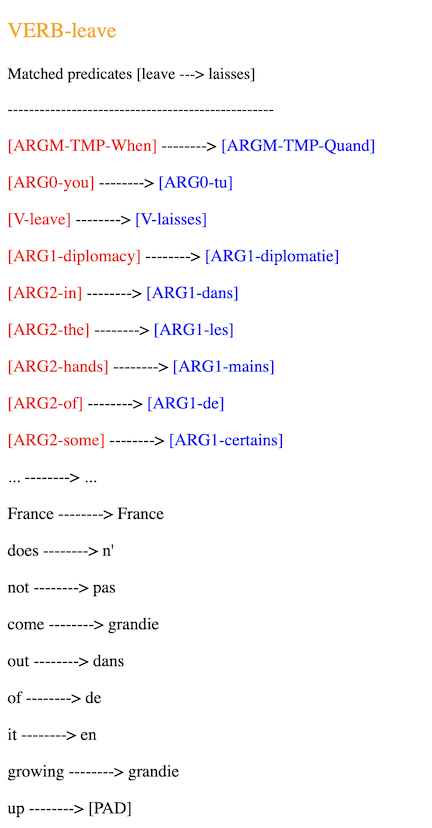


The size of test data set is 2 percent of dataset

> The size of entire data set : 25549

> The size of test data set : 511

<mark>After you have completed the function and executed the test, make sure to transfer your answer to the .py file provided along with this Notebook<mark>


In [ ]:
if __name__ == "__main__":
    with open("Project03/data/fr_obj_test.pkl", "rb") as fp:
        fr_objs = pickle.load(fp)
    with open("Project03/data/en_obj_test.pkl", "rb") as fp:
        en_objs = pickle.load(fp)

    fr_obj = fr_objs[0]
    en_obj = en_objs[0]

In [ ]:
def get_tokens(fr_obj, en_obj) -> tuple:
    french_tokens = fr_obj["tokens"]
    english_tokens = en_obj["tokens"]

    return (french_tokens, english_tokens)

In [ ]:
if __name__ == "__main__":

    french_tokens, english_tokens = get_tokens(fr_obj, en_obj)
    french_bool = french_tokens == [
        "Quand",
        "tu",
        "laisses",
        "la",
        "diplomatie",
        "dans",
        "les",
        "mains",
        "de",
        "certains",
        "...",
        "la",
        "France",
        "n'",
        "en",
        "sort",
        "pas",
        "grandie",
    ]
    english_bool = english_tokens == [
        "When",
        "you",
        "leave",
        "diplomacy",
        "in",
        "the",
        "hands",
        "of",
        "some",
        "...",
        "France",
        "does",
        "not",
        "come",
        "out",
        "of",
        "it",
        "growing",
        "up",
    ]

    if french_bool == english_bool == True:
        print("Test passed")
    else:
        print("Test failed")

In [ ]:
if __name__ == "__main__":
    with open("Project03/data/fr_obj_test.pkl", "rb") as fp:
        fr_objs = pickle.load(fp)
    with open("Project03/data/en_obj_test.pkl", "rb") as fp:
        en_objs = pickle.load(fp)
    with open("Project03/data/align_result.pkl", "rb") as fp:
        aligns = pickle.load(fp)
    for i, (fr_obj, en_obj, decoded) in enumerate(zip(fr_objs, en_objs, aligns)):
        french_tokens, english_tokens = get_tokens(fr_obj, en_obj)
        print("-" * 35, "Start {}".format(i), "-" * 35)
        print(
            "French sentence : {}\nEnglish sentence :{}".format(
                fr_obj["sent"], en_obj["sent"]
            )
        )
        view(
            en_obj,
            fr_obj,
            decoded,
            "Project03/saving_files/srl_align_result.html",
            i,
        )

# Part 9. Evaluate French SRL using Precision, Recall, and F-1 score

Evaluate model performance using an SRL-adapted Precision, Recall and F-1 score. In this part, a weighted average method is used for the measure.

**True Positive** : Both the English token and French token have same non-O SRL or B-V.

**False Positive** : English token is labeled ("O") and French token has a non-O label (SRL or B-V), or English token and French token have mismatched labels non-O labels (SRL or B-V).

**True Negative** : Both the English token and the French token are labeled "O" (no SRL or B-V).

**False Negative** : English token has SRL or B-V and French token is labeled "O" (no SRL or B-V).


In [ ]:
if __name__ == "__main__":

    with open("Project03/data/fr_obj_test.pkl", "rb") as fp:
        fr_objs = pickle.load(fp)
    with open("Project03/data/en_obj_test.pkl", "rb") as fp:
        en_objs = pickle.load(fp)
    with open("Project03/data/align_result.pkl", "rb") as fp:
        aligns = pickle.load(fp)

    confu_pairs = []

    for i, (fr_obj, en_obj, decoded) in enumerate(zip(fr_objs, en_objs, aligns)):

        french_tokens, english_tokens = get_tokens(fr_obj, en_obj)
        pair_items = measure(en_obj, fr_obj, decoded)
        confu_pairs.extend(pair_items)

**Expected output**

```
{'TP': 1376, 'TN': 4737, 'FP': 661, 'FN': 2001}
```


In [ ]:
result_dict = confu_matrix(confu_pairs)
result_dict = {
    key: val
    for key, val in sorted(result_dict.items(), key=lambda x: x[0], reverse=True)
}
print(result_dict)

Precsion(P) = TP / (TP+FP)

Recall(R) = TP / (TP+FN)

F1-score = (2* Precision *Recall) / (Precision+Recall)

In this programming question, you should use equivalent formula,

**(2 _ TP) / (2 _ TP + FP + FN)**

to compute **f-1 score** faster and directly, and you compare f-1 score to one that computed using formula below using precision and recall

**(2* Precision *Recall) / (Precision+Recall)**

In [ ]:
def precision_recall_f1(confusion_matrix: dict) -> tuple:
    TP = confusion_matrix.get("TP", 0)
    FP = confusion_matrix.get("FP", 0)
    FN = confusion_matrix.get("FN", 0)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
    return (precision, recall, f1)

**Expected output**

```
Precision 0.676, Recall 0.407, F1-score 0.508
```


In [ ]:
precision, recall, f1 = precision_recall_f1(result_dict)
print(f"Precision %.3f, Recall %.3f, F1-score %.3f " % (precision, recall, f1))

In [ ]:
equivalent_f_1 = (2 * precision * recall) / (precision + recall)
answer = equivalent_f_1 == f1
print(f"Your f-1 score is %s" % (answer))